In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [4]:
df = pd.read_csv(r'C:\Users\acer\Desktop\SNLP\SNLP_Assignments_Sem7_J065\Assignment 0\spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

Dataset Shape: (5572, 2)
label
0    4825
1     747
Name: count, dtype: int64


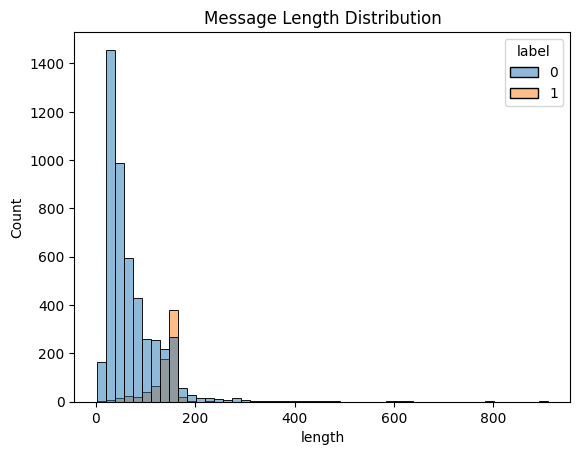

In [5]:
print("Dataset Shape:", df.shape)
print(df['label'].value_counts())
df['length'] = df['text'].apply(len)
sns.histplot(data=df, x='length', hue='label', bins=50)
plt.title('Message Length Distribution')
plt.show()

In [7]:
stop_words = set(stopwords.words('english'))

def preprocess_tokens(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t not in stop_words and t.isalpha()]

def get_ngrams(texts, n=1):
    all_tokens = []
    for text in texts:
        tokens = preprocess_tokens(text)
        all_tokens += list(ngrams(tokens, n))
    return Counter(all_tokens).most_common(10)

In [10]:
ham_texts = df[df['label'] == 0]['text']
spam_texts = df[df['label'] == 1]['text']

print("Top 10 Words - HAM:", get_ngrams(ham_texts, 1))
print("Top 10 Words - SPAM:", get_ngrams(spam_texts, 1))
print("Top 10 Bigrams - HAM:", get_ngrams(ham_texts, 2))
print("Top 10 Bigrams - SPAM:", get_ngrams(spam_texts, 2))
print("Top 10 Trigrams - HAM:", get_ngrams(ham_texts, 3))
print("Top 10 Trigrams - SPAM:", get_ngrams(spam_texts, 3))

Top 10 Words - HAM: [(('u',), 979), (('gt',), 318), (('lt',), 316), (('get',), 301), (('go',), 248), (('ok',), 245), (('got',), 242), (('ur',), 237), (('know',), 236), (('like',), 231)]
Top 10 Words - SPAM: [(('call',), 346), (('free',), 219), (('txt',), 156), (('ur',), 144), (('u',), 141), (('mobile',), 123), (('text',), 121), (('stop',), 114), (('claim',), 113), (('reply',), 104)]
Top 10 Bigrams - HAM: [(('lt', 'gt'), 276), (('gon', 'na'), 58), (('call', 'later'), 50), (('let', 'know'), 39), (('sorry', 'call'), 38), (('r', 'u'), 37), (('u', 'r'), 35), (('good', 'morning'), 31), (('take', 'care'), 31), (('u', 'wan'), 29)]
Top 10 Bigrams - SPAM: [(('please', 'call'), 45), (('po', 'box'), 24), (('guaranteed', 'call'), 23), (('prize', 'guaranteed'), 22), (('call', 'landline'), 22), (('selected', 'receive'), 19), (('send', 'stop'), 19), (('every', 'week'), 19), (('await', 'collection'), 19), (('call', 'claim'), 18)]
Top 10 Trigrams - HAM: [(('sorry', 'call', 'later'), 38), (('lt', 'decima

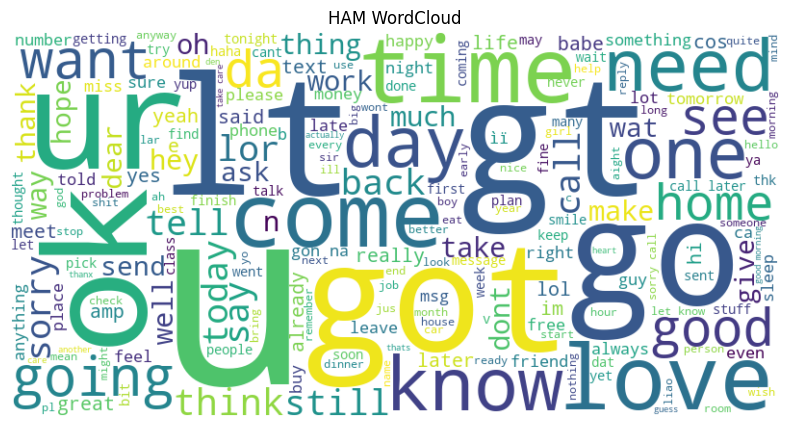

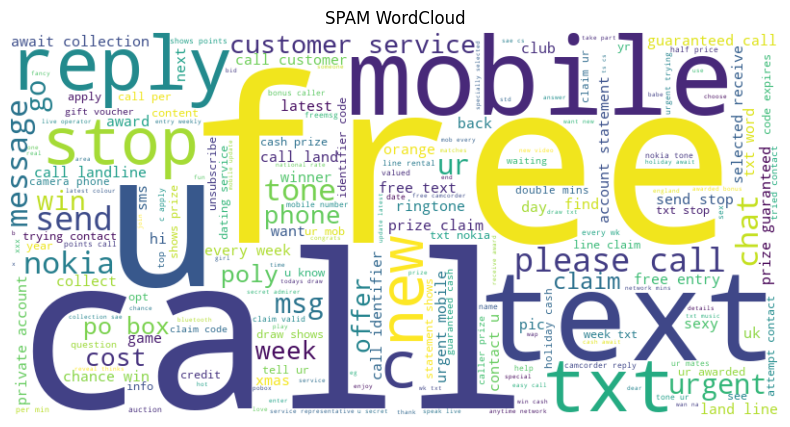

In [11]:
def show_wordcloud(texts, title):
    text = ' '.join(texts)
    tokens = preprocess_tokens(text)
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_wordcloud(ham_texts, 'HAM WordCloud')
show_wordcloud(spam_texts, 'SPAM WordCloud')

In [ ]:
def train_model(vectorizer, X_train, X_test, y_train, y_test):
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    return f1_score(y_test, y_pred), classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# BoW
bow_vectorizer = CountVectorizer()
bow_f1, _ = train_model(bow_vectorizer, X_train, X_test, y_train, y_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_f1, _ = train_model(tfidf_vectorizer, X_train, X_test, y_train, y_test)

print(f"F1-Score (BoW): {bow_f1:.4f}")
print(f"F1-Score (TF-IDF): {tfidf_f1:.4f}")


F1-Score (BoW): 0.9097
F1-Score (TF-IDF): 0.8647


In [13]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|<.*?>|\S+@\S+', '', text)  # URLs, emails, HTML
    text = re.sub(r'\d+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# TF-IDF with Preprocessing
tfidf_clean_vectorizer = TfidfVectorizer()
tfidf_clean_f1, _ = train_model(tfidf_clean_vectorizer, X_train, X_test, y_train, y_test)
print(f"F1-Score (TF-IDF + Cleaned): {tfidf_clean_f1:.4f}")

F1-Score (TF-IDF + Cleaned): 0.7778


In [14]:
# Cell 9: Summary
results = pd.DataFrame({
    'Method': ['Bag of Words', 'TF-IDF', 'TF-IDF + Preprocessing'],
    'F1-Score': [bow_f1, tfidf_f1, tfidf_clean_f1]
})
print(results)


                   Method  F1-Score
0            Bag of Words  0.909747
1                  TF-IDF  0.864662
2  TF-IDF + Preprocessing  0.777778
